## ENTRENAMIENTO SIN VALIDACIÓN CRUZADA

✅ Encontrados 225 parches JPEG en data\raw\pnoa
X shape: (225, 256, 256, 4) | y shape: (225, 256, 256, 1)
🧪 Train: 180 imágenes | Val: 45
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 sequential_5 (Sequential)      (None, 256, 256, 4)  0           ['input_11[0][0]']               
                                                                                                  
 proj_4to3 (Conv2D)             (None, 256, 256, 3)  15          ['sequential_5[0][0]']           
                                                    

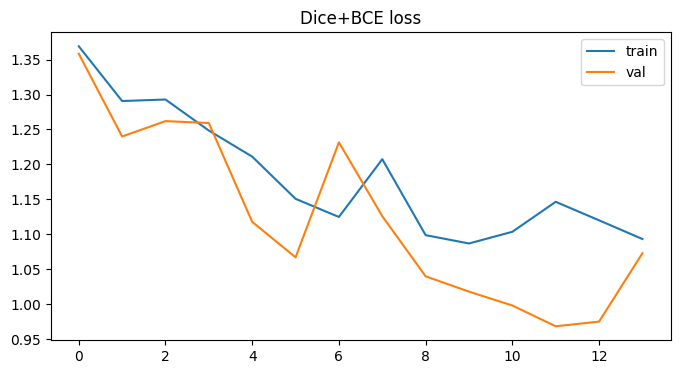

In [ ]:
# notebooks/03_Preentrenamiento_con_UNET_ligero.ipynb

# ------------------------------------------------------------------
# 0. IMPORTS Y CONFIGURACIÓN
# ------------------------------------------------------------------
from pathlib import Path
import numpy as np
import tensorflow as tf
import rasterio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sys
from tensorflow.keras.losses import BinaryCrossentropy

PROJECT_ROOT = Path().resolve().parent
SCRIPT_DIR   = PROJECT_ROOT / "scripts"
if str(SCRIPT_DIR) not in sys.path:
    sys.path.append(str(SCRIPT_DIR))

from model_utils import load_unet_with_mobilenet, dice_loss

# reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

# ------------------------------------------------------------------
# 1. PATHS
# ------------------------------------------------------------------
RAW_DIR       = PROJECT_ROOT / "data" / "raw" / "pnoa"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
MODEL_DIR     = PROJECT_ROOT / "models"
MODEL_DIR.mkdir(exist_ok=True)

# ------------------------------------------------------------------
# 2. CARGA Y PREPROCESADO DE DATOS
# ------------------------------------------------------------------
import tensorflow as _tf # evitar conflictos

def compute_exg(img):
    R, G, B = _tf.split(img, 3, axis=-1)
    exg = 2*G - R - B
    mn, mx = _tf.reduce_min(exg), _tf.reduce_max(exg)
    return (exg - mn) / (mx - mn + 1e-6)


def load_image_mask(tile_jpg: Path, target_size=(256,256)):
    mask_tif = PROCESSED_DIR / f"{tile_jpg.stem}_MASK.tif"
    assert mask_tif.exists(), f"❌ Falta máscara para {tile_jpg.name}"
    # Leer JPEG RGB
    with rasterio.open(tile_jpg) as src:
        img = src.read([1,2,3]).transpose(1,2,0).astype(np.float32)
    img = _tf.image.resize(img, target_size) / 255.0
    # Calcular ExG y concatenar
    exg = compute_exg(img)
    img4 = _tf.concat([img, exg], axis=-1)

    # Leer máscara
    with rasterio.open(mask_tif) as src:
        msk = src.read(1).astype(np.float32)
    msk = _tf.image.resize(msk[...,None], target_size, method='nearest')
    msk = _tf.squeeze(msk)
    msk = _tf.where(msk > 0.5, 1.0, 0.0)

    return img4.numpy(), msk.numpy()

# Cargar todos los parches
image_paths = sorted(RAW_DIR.glob("valencia_tile_*.jpg"))
print(f"✅ Encontrados {len(image_paths)} parches JPEG en {RAW_DIR.relative_to(PROJECT_ROOT)}")

data = [load_image_mask(p) for p in image_paths]
X, y = zip(*data)
X = np.array(X, dtype=np.float32)
y = np.expand_dims(np.array(y, dtype=np.float32), -1)
print(f"X shape: {X.shape} | y shape: {y.shape}")

# ------------------------------------------------------------------
# 3. SPLIT TRAIN-VAL
# ------------------------------------------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)
print(f"🧪 Train: {X_train.shape[0]} imágenes | Val: {X_val.shape[0]}")

# ------------------------------------------------------------------
# 4. DATA AUGMENTATION VIA TF.DATA
# ------------------------------------------------------------------
def tf_augment(img4, msk):
    # separar RGB y ExG
    rgb, exg = _tf.split(img4, [3,1], axis=-1)
    # flips y rotaciones
    rgb = _tf.image.random_flip_left_right(rgb); exg = _tf.image.random_flip_left_right(exg)
    rgb = _tf.image.random_flip_up_down(rgb);    exg = _tf.image.random_flip_up_down(exg)
    k = _tf.random.uniform((),0,4,_tf.int32)
    rgb = _tf.image.rot90(rgb, k);               exg = _tf.image.rot90(exg, k)
    # ajuste de color solo RGB
    rgb = _tf.image.random_brightness(rgb, 0.2)
    rgb = _tf.image.random_contrast(rgb, 0.7, 1.3)
    rgb = _tf.image.random_saturation(rgb, 0.7, 1.3)
    # reconstruir 4 canales
    img4 = _tf.concat([rgb, exg], axis=-1)
    return _tf.clip_by_value(img4, 0, 1), msk

batch_size = 8
AUTOTUNE   = tf.data.AUTOTUNE

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
      .shuffle(len(X_train))
      .map(tf_augment, num_parallel_calls=AUTOTUNE)
      .batch(batch_size).prefetch(AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
      .batch(batch_size).prefetch(AUTOTUNE)
)

# ------------------------------------------------------------------
# 5. LOSS COMBINADA (DICE + BCE)
# ------------------------------------------------------------------
bce = BinaryCrossentropy()
def combined_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + bce(y_true, y_pred)

# ------------------------------------------------------------------
# 6. MODELO
# ------------------------------------------------------------------
model = load_unet_with_mobilenet(input_shape=(256,256,4))
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=combined_loss,
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.MeanIoU(num_classes=2, name='iou')
    ]
)
model.summary()

# ------------------------------------------------------------------
# 7. CALLBACKS
# ------------------------------------------------------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_precision', mode='max', patience=8, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
]


# ------------------------------------------------------------------
# 8. ENTRENAMIENTO
# ------------------------------------------------------------------
EPOCHS = 50
print("\n🔥 Comenzando entrenamiento... (hasta {} epocas)".format(EPOCHS))
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2
)

# ------------------------------------------------------------------
# 9. GUARDADO MODELO FINAL
# ------------------------------------------------------------------
model.save(MODEL_DIR / 'model_sin_CV.h5')
print(f"\n✅ Modelo final guardado en {MODEL_DIR.relative_to(PROJECT_ROOT)}")

# ------------------------------------------------------------------
# 10. CURVAS DE APRENDIZAJE
# ------------------------------------------------------------------
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Dice+BCE loss'); plt.legend(); plt.show()


## ENTRENAMIENTO CON VALIDACIÓN CRUZADA (5 K-Fold)

✅ 225 imágenes en data\raw\pnoa


c:\Users\lakme\anaconda3\Lib\site-packages\rasterio\__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


X shape: (225, 256, 256, 4) y shape: (225, 256, 256, 1)

=== Fold 1/5 ===
Epoch 1/50
23/23 - 264s - loss: 1.2972 - precision: 0.2121 - recall: 0.0459 - iou: 0.4246 - val_loss: 1.2004 - val_precision: 0.0044 - val_recall: 1.7582e-05 - val_iou: 0.4325 - lr: 0.0010 - 264s/epoch - 11s/step
Epoch 2/50
23/23 - 247s - loss: 1.2529 - precision: 0.2112 - recall: 0.0381 - iou: 0.4247 - val_loss: 1.4534 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_iou: 0.4325 - lr: 0.0010 - 247s/epoch - 11s/step
Epoch 3/50
23/23 - 246s - loss: 1.1165 - precision: 0.5860 - recall: 0.2320 - iou: 0.4248 - val_loss: 1.0567 - val_precision: 0.6395 - val_recall: 0.3873 - val_iou: 0.4325 - lr: 0.0010 - 246s/epoch - 11s/step
Epoch 4/50
23/23 - 242s - loss: 1.1850 - precision: 0.4500 - recall: 0.2480 - iou: 0.4246 - val_loss: 1.0412 - val_precision: 0.4500 - val_recall: 0.7486 - val_iou: 0.4325 - lr: 0.0010 - 242s/epoch - 11s/step
Epoch 5/50
23/23 - 243s - loss: 1.0301 - precision: 0.5263 - recall: 0.4863 - 

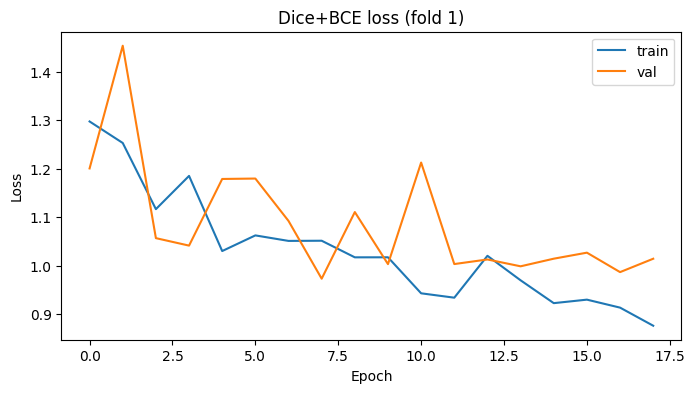


=== Fold 2/5 ===
Epoch 1/50
23/23 - 262s - loss: 1.3588 - precision: 0.0029 - recall: 6.8193e-04 - iou: 0.4341 - val_loss: 1.3407 - val_precision: 0.1215 - val_recall: 2.0905e-05 - val_iou: 0.3946 - lr: 0.0010 - 262s/epoch - 11s/step
Epoch 2/50
23/23 - 247s - loss: 1.3037 - precision: 0.1500 - recall: 1.7370e-05 - iou: 0.4341 - val_loss: 1.4165 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_iou: 0.3946 - lr: 0.0010 - 247s/epoch - 11s/step
Epoch 3/50
23/23 - 242s - loss: 1.2911 - precision: 0.0910 - recall: 7.6557e-05 - iou: 0.4341 - val_loss: 1.4651 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_iou: 0.3946 - lr: 0.0010 - 242s/epoch - 11s/step
Epoch 4/50
23/23 - 241s - loss: 1.2893 - precision: 0.0000e+00 - recall: 0.0000e+00 - iou: 0.4341 - val_loss: 1.3821 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_iou: 0.3946 - lr: 0.0010 - 241s/epoch - 10s/step
Epoch 5/50
23/23 - 241s - loss: 1.2789 - precision: 0.0000e+00 - recall: 0.0000e+00 - iou: 0.4341 

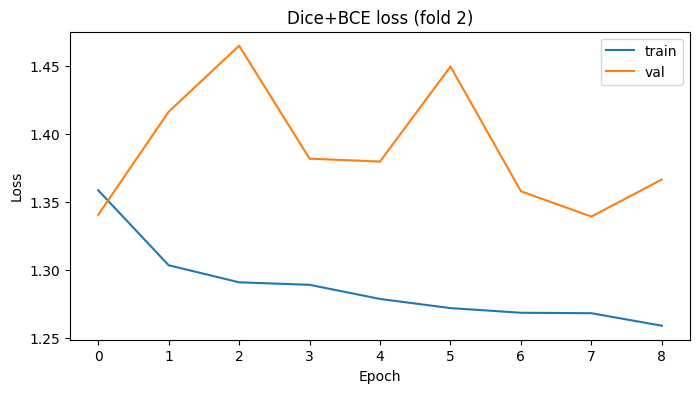


=== Fold 3/5 ===
Epoch 1/50
23/23 - 256s - loss: 1.4115 - precision: 0.2295 - recall: 0.0451 - iou: 0.4237 - val_loss: 1.2487 - val_precision: 0.0973 - val_recall: 5.8613e-05 - val_iou: 0.4364 - lr: 0.0010 - 256s/epoch - 11s/step
Epoch 2/50
23/23 - 241s - loss: 1.3358 - precision: 0.5163 - recall: 0.1134 - iou: 0.4249 - val_loss: 1.2522 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_iou: 0.4364 - lr: 0.0010 - 241s/epoch - 10s/step
Epoch 3/50
23/23 - 240s - loss: 1.2394 - precision: 0.2414 - recall: 0.0014 - iou: 0.4237 - val_loss: 1.1659 - val_precision: 0.1875 - val_recall: 5.9945e-04 - val_iou: 0.4364 - lr: 0.0010 - 240s/epoch - 10s/step
Epoch 4/50
23/23 - 239s - loss: 1.1665 - precision: 0.3735 - recall: 0.0429 - iou: 0.4237 - val_loss: 1.0934 - val_precision: 0.4945 - val_recall: 0.0719 - val_iou: 0.4364 - lr: 0.0010 - 239s/epoch - 10s/step
Epoch 5/50
23/23 - 242s - loss: 1.1165 - precision: 0.4832 - recall: 0.2934 - iou: 0.4237 - val_loss: 1.2759 - val_precision: 0.23

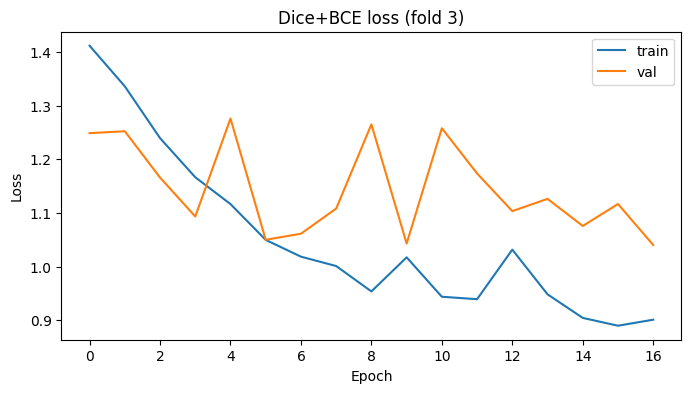


=== Fold 4/5 ===
Epoch 1/50
23/23 - 253s - loss: 1.3704 - precision: 0.1719 - recall: 0.0628 - iou: 0.4242 - val_loss: 1.2805 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_iou: 0.4344 - lr: 0.0010 - 253s/epoch - 11s/step
Epoch 2/50
23/23 - 235s - loss: 1.3261 - precision: 0.0000e+00 - recall: 0.0000e+00 - iou: 0.4242 - val_loss: 1.3145 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_iou: 0.4344 - lr: 0.0010 - 235s/epoch - 10s/step
Epoch 3/50
23/23 - 234s - loss: 1.2957 - precision: 0.1829 - recall: 8.3832e-06 - iou: 0.4242 - val_loss: 1.2858 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_iou: 0.4344 - lr: 0.0010 - 234s/epoch - 10s/step
Epoch 4/50
23/23 - 234s - loss: 1.2891 - precision: 0.0000e+00 - recall: 0.0000e+00 - iou: 0.4242 - val_loss: 1.2820 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_iou: 0.4344 - lr: 0.0010 - 234s/epoch - 10s/step
Epoch 5/50
23/23 - 227s - loss: 1.2836 - precision: 0.0000e+00 - recall: 0.0000e+00 - iou: 0.4

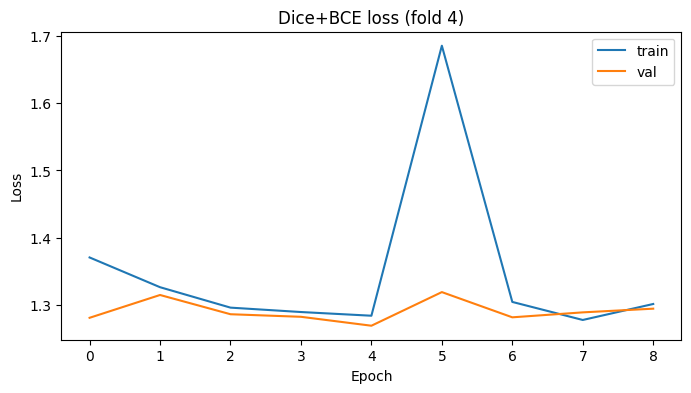


=== Fold 5/5 ===
Epoch 1/50
23/23 - 249s - loss: 1.3581 - precision: 0.1638 - recall: 0.0462 - iou: 0.4245 - val_loss: 1.3343 - val_precision: 0.2000 - val_recall: 2.2845e-05 - val_iou: 0.4332 - lr: 0.0010 - 249s/epoch - 11s/step
Epoch 2/50
23/23 - 236s - loss: 1.3066 - precision: 0.1538 - recall: 3.3664e-06 - iou: 0.4245 - val_loss: 1.3063 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_iou: 0.4332 - lr: 0.0010 - 236s/epoch - 10s/step
Epoch 3/50
23/23 - 236s - loss: 1.2815 - precision: 1.0000 - recall: 5.3975e-04 - iou: 0.4245 - val_loss: 1.3269 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_iou: 0.4332 - lr: 0.0010 - 236s/epoch - 10s/step
Epoch 4/50
23/23 - 229s - loss: 1.3262 - precision: 0.3051 - recall: 2.0198e-05 - iou: 0.4245 - val_loss: 1.2974 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_iou: 0.4332 - lr: 0.0010 - 229s/epoch - 10s/step
Epoch 5/50
23/23 - 234s - loss: 1.2989 - precision: 0.1073 - recall: 0.0096 - iou: 0.4245 - val_loss: 1.36

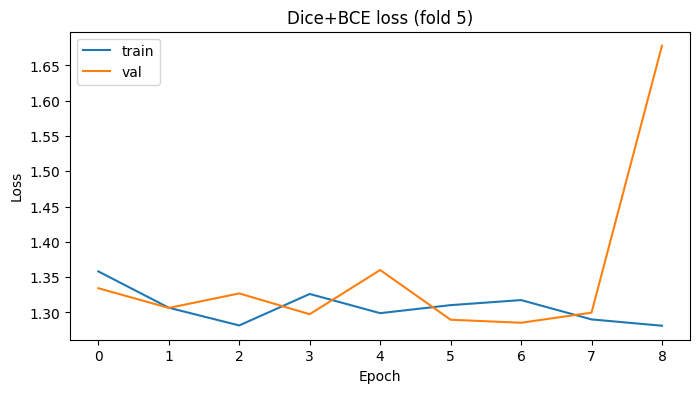


=== CV promedio ===
loss        : 1.2387
precision   : 0.3390
recall      : 0.1354
iou         : 0.4262

🎉 Mejor fold: 1 (val_loss=0.9730)
✅ Guardado como 'models\bestmodel_fold1.h5'


In [ ]:
# notebooks/03_Preentrenamiento_con_UNET_ligero.ipynb

# ------------------------------------------------------------------
# 0. IMPORTS Y CONFIGURACIÓN
# ------------------------------------------------------------------
from pathlib import Path
import numpy as np
import tensorflow as tf
import rasterio
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import sys
from tensorflow.keras.losses import BinaryCrossentropy

PROJECT_ROOT = Path().resolve().parent
SCRIPT_DIR   = PROJECT_ROOT / "scripts"
if str(SCRIPT_DIR) not in sys.path:
    sys.path.append(str(SCRIPT_DIR))

from test_model_utils import load_unet_with_mobilenet, dice_loss

# reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

# ------------------------------------------------------------------
# 1. PATHS 
# ------------------------------------------------------------------
RAW_DIR       = PROJECT_ROOT / "data" / "raw" / "pnoa"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
MODEL_DIR     = PROJECT_ROOT / "models"
MODEL_DIR.mkdir(exist_ok=True)

# ------------------------------------------------------------------
# 2. CARGA Y PREPROCESADO DE DATOS
# ------------------------------------------------------------------
def load_image_mask(tile_jpg, target_size=(256,256)):
    mask_tif = PROCESSED_DIR / f"{tile_jpg.stem}_MASK.tif"
    assert mask_tif.exists(), f"Falta máscara {mask_tif.name}"
    with rasterio.open(tile_jpg) as src:
        img = src.read([1,2,3]).transpose(1,2,0).astype(np.float32)
    img = tf.image.resize(img, target_size) / 255.0
    exg = compute_exg(img)                      # shape (256,256,1)       
    img4 = tf.concat([img, exg], axis=-1)       # shape (256,256,4)

    with rasterio.open(mask_tif) as src:
        msk = src.read(1).astype(np.float32)
    msk = tf.image.resize(msk[...,None], target_size, method='nearest')
    msk = tf.squeeze(msk)
    msk = tf.where(msk>0.5,1.0,0.0)
    return img4.numpy(), msk.numpy()

def compute_exg(img):
    # img es un tensor de TensorFlow (256,256,3)
    R, G, B = tf.split(img, 3, axis=-1)  # Divide en canales
    exg = 2*G - R - B
    exg_min = tf.reduce_min(exg)
    exg_max = tf.reduce_max(exg)
    return (exg - exg_min) / (exg_max - exg_min + 1e-6)

paths = sorted(RAW_DIR.glob("valencia_tile_*.jpg"))
print(f"✅ {len(paths)} imágenes en {RAW_DIR.relative_to(PROJECT_ROOT)}")

data = [load_image_mask(p) for p in paths]
X, y = zip(*data)
X = np.array(X, dtype=np.float32)
y = np.expand_dims(np.array(y, dtype=np.float32), -1)
print("X shape:", X.shape, "y shape:", y.shape)

# ------------------------------------------------------------------
# 3. DATA AUGMENTATION VIA TF.DATA
# ------------------------------------------------------------------
def tf_augment(img4, msk):
    # 1) Separa RGB (3 canales) y ExG (1 canal)
    rgb, exg = tf.split(img4, [3,1], axis=-1)

    # 2) Aplica flips y rotaciones idénticos a ambos
    rgb = tf.image.random_flip_left_right(rgb)
    exg = tf.image.random_flip_left_right(exg)
    rgb = tf.image.random_flip_up_down(rgb)
    exg = tf.image.random_flip_up_down(exg)
    k = tf.random.uniform((), 0, 4, tf.int32)
    rgb = tf.image.rot90(rgb, k)
    exg = tf.image.rot90(exg, k)

    # 3) Sólo al RGB, aplica brillo/contraste/saturación
    rgb = tf.image.random_brightness(rgb, 0.2)
    rgb = tf.image.random_contrast(rgb, 0.7, 1.3)
    rgb = tf.image.random_saturation(rgb, 0.7, 1.3)

    # 4) Reconstruye el tensor 4-canal
    img4 = tf.concat([rgb, exg], axis=-1)
    return tf.clip_by_value(img4, 0, 1), msk

batch_size = 8
AUTOTUNE   = tf.data.AUTOTUNE

# ------------------------------------------------------------------
# 4. LOSS COMBINADA (DICE + BCE) PARA REDUCIR RECALL
# ------------------------------------------------------------------
bce = BinaryCrossentropy()
def combined_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + bce(y_true, y_pred)

# ------------------------------------------------------------------
# 5. ENTRENAMIENTO CON VALIDACIÓN CRUZADA
# ------------------------------------------------------------------
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
all_metrics = []

# Variables para trackear el mejor fold
best_val_loss = np.inf
best_fold = None
best_model = None

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f"\n=== Fold {fold}/{n_splits} ===")

    X_tr, X_va = X[train_idx], X[val_idx]
    y_tr, y_va = y[train_idx], y[val_idx]

    train_ds = (tf.data.Dataset
                .from_tensor_slices((X_tr, y_tr))
                .shuffle(len(X_tr))
                .map(tf_augment, num_parallel_calls=AUTOTUNE)
                .batch(batch_size).prefetch(AUTOTUNE))
    val_ds = (tf.data.Dataset
              .from_tensor_slices((X_va, y_va))
              .batch(batch_size).prefetch(AUTOTUNE))

    # Nuevo modelo por fold
    model = load_unet_with_mobilenet(input_shape=(256,256,4))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=combined_loss,
        metrics=[
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.MeanIoU(num_classes=2, name='iou')
        ]
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss',     patience=10, restore_best_weights=True),
        tf.keras.callbacks.EarlyStopping(monitor='val_precision',mode='max',patience=8,  restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks,
        verbose=2
    )

    # Evaluar en validación
    scores = model.evaluate(val_ds, verbose=0)
    names  = model.metrics_names
    metrics = dict(zip(names, scores))
    print(f"-> Fold {fold} metrics:", metrics)
    all_metrics.append([metrics[m] for m in names])

    # Guardar modelo de este fold
    fold_path = MODEL_DIR / f"Modelo_CV_fold{fold}.h5"
    model.save(fold_path)
    print(f"✅ Guardado modelo fold {fold} en '{fold_path.relative_to(PROJECT_ROOT)}'")

    # Plot de curvas de loss de este fold
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'],     label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f'Dice+BCE loss (fold {fold})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Actualizar el mejor fold según val_loss mínimo
    min_val = min(history.history['val_loss'])
    if min_val < best_val_loss:
        best_val_loss = min_val
        best_fold = fold
        best_model = model

# ------------------------------------------------------------------
# 6. RESULTADOS PROMEDIO
# ------------------------------------------------------------------
all_metrics = np.array(all_metrics)
avg = all_metrics.mean(axis=0)
print("\n=== CV promedio ===")
for name, val in zip(names, avg):
    print(f"{name:12s}: {val:.4f}")

# ------------------------------------------------------------------
# 7. GUARDAR MEJOR MODELO
# ------------------------------------------------------------------
if best_fold is not None:
    best_path = MODEL_DIR / f"Mejor_modelo_CV_en_fold{best_fold}.h5"
    best_model.save(best_path)
    print(f"\n🎉 Mejor fold: {best_fold} (val_loss={best_val_loss:.4f})")
    print(f"✅ Guardado como '{best_path.relative_to(PROJECT_ROOT)}'")
else:
    print("No se identificó un mejor fold.")
